# Analisi dei dati raccolti

## Setup

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from types import FunctionType

In [25]:
def plotter(dataframes: list, index: str, names: list, space: int) -> None:
    xvalues_int = list()
    xvalues_str = list()
    for name in names:
        xvalues_str.extend(["", name, ""])

    plt.gcf().set_size_inches(10, 6)
    plt.title("Hashing")
    plt.ylabel("Tempo di esecuzione")
    
    start = 1
    ymax = 0
    for dataframe in dataframes:
        series = dataframe[index]
        ymax = max(ymax, max(series))
        x = [start, start+1, start+2]
        xvalues_int.extend(x)
        plt.bar(x, [series.min(), series.mean(), series.max()])
        start += 5
    
    plt.xticks(xvalues_int, xvalues_str, rotation=90)
    plt.yticks([i for i in range(0, ymax+space, space)])
    plt.grid(axis="y")
    
    plt.show()

In [26]:
PATH = "../asconhashbi32v12/data/{}.csv"

IMPLEMENTATIONS = [
    "bi32", "bi32_armv7m", "bi32_lowreg", "bi32_lowsize", "ref"
]

bi32 = pd.read_csv(open(PATH.format("bi32"), "r"), delimiter=";")
bi32_armv7m = pd.read_csv(open(PATH.format("bi32_armv7m"), "r"), delimiter=";")
bi32_lowreg = pd.read_csv(open(PATH.format("bi32_lowreg"), "r"), delimiter=";")
bi32_lowsize = pd.read_csv(open(PATH.format("bi32_lowsize"), "r"), delimiter=";")
ref = pd.read_csv(open(PATH.format("ref"), "r"), delimiter=";")

DATAFRAMES = [
    bi32, bi32_armv7m, bi32_lowreg, bi32_lowsize, ref
]

INDEX = bi32.columns

## Grafici

Ogni grafico presente in questo notebook è suddiviso in cinque parti, ognuna delle quali contiene una rappresentazione dei dati raccolti durante il testing in fase di generazione dell'hash di una data implementazione

Le implementazioni, che vanno a indicizzare l'asse delle X, vengono rappresentate da tre barre:
* la barra di sinistra rappresenta il valore **minimo**
* la barra centrale rappresenta il valore **medio**
* la barra di destra rappresenta il valore **massimo**

I valori sull'asse Y rappresentano il tempo di esecuzione in **microsecondi**

### PT vuoto

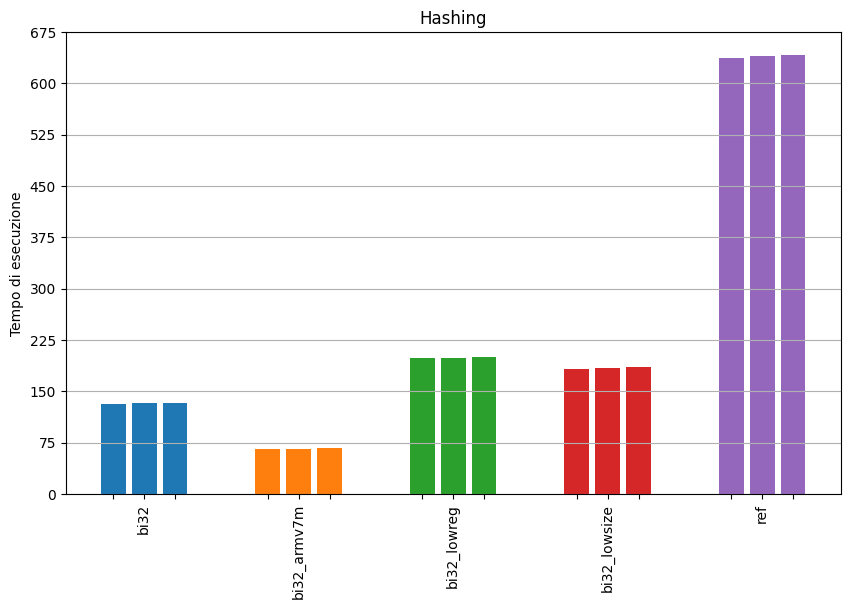

In [27]:
# Generazione hash
plotter(DATAFRAMES, "0B", IMPLEMENTATIONS, 75)

### PT 8 byte

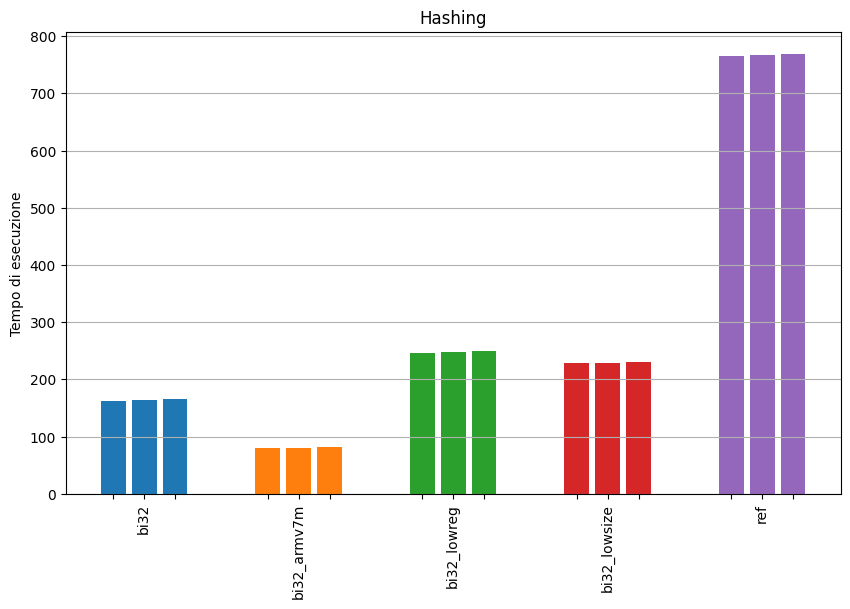

In [28]:
# Generazione hash
plotter(DATAFRAMES, "8B", IMPLEMENTATIONS, 100)

### PT 16 byte

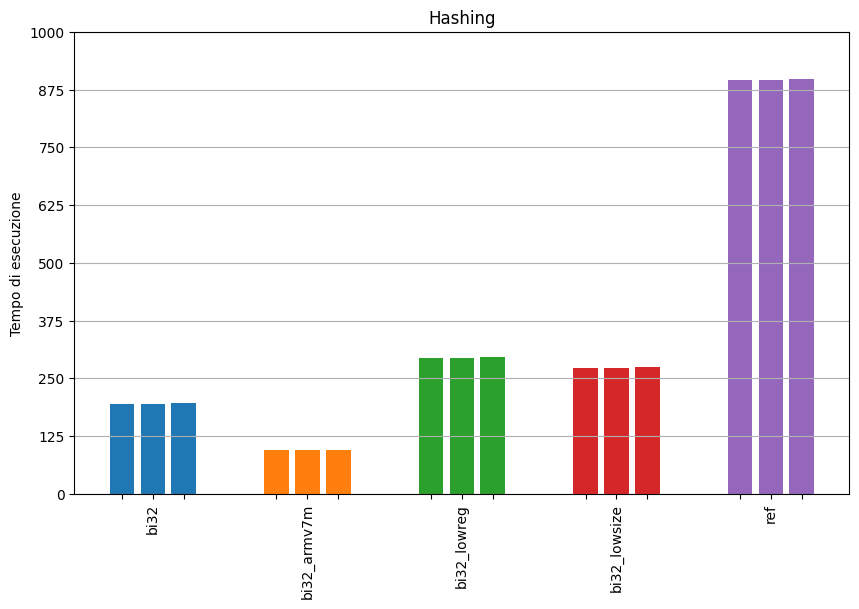

In [29]:
# Generazione hash
plotter(DATAFRAMES, "16B", IMPLEMENTATIONS, 125)

### PT 32 byte

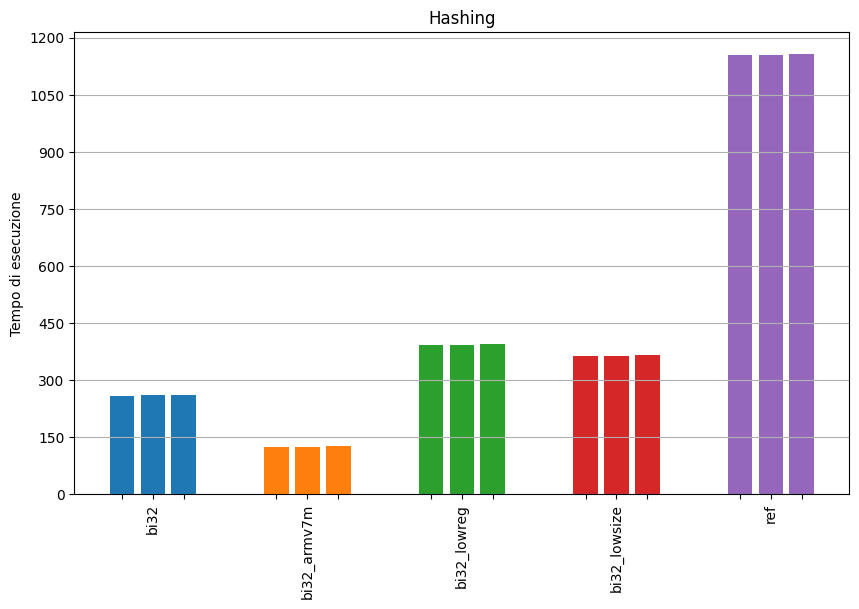

In [30]:
# Generazione hash
plotter(DATAFRAMES, "32B", IMPLEMENTATIONS, 150)

### PT 64 byte

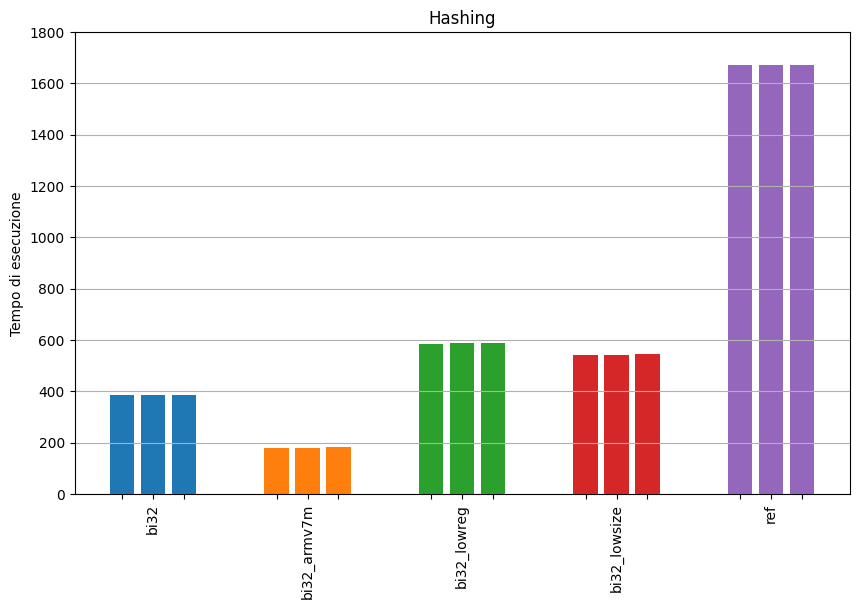

In [31]:
# Generazione hash
plotter(DATAFRAMES, "64B", IMPLEMENTATIONS, 200)

### PT 128 byte

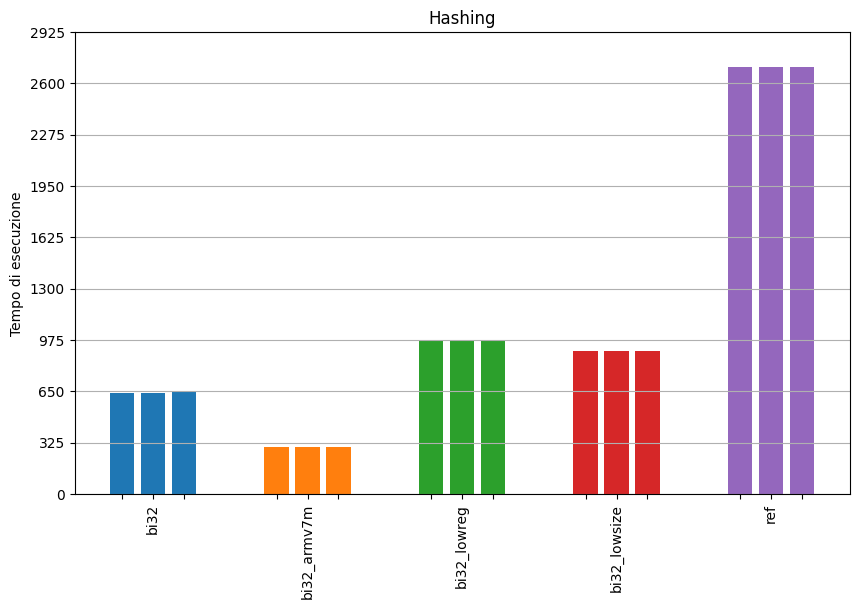

In [32]:
# Generazione hash
plotter(DATAFRAMES, "128B", IMPLEMENTATIONS, 325)

### PT 256 byte

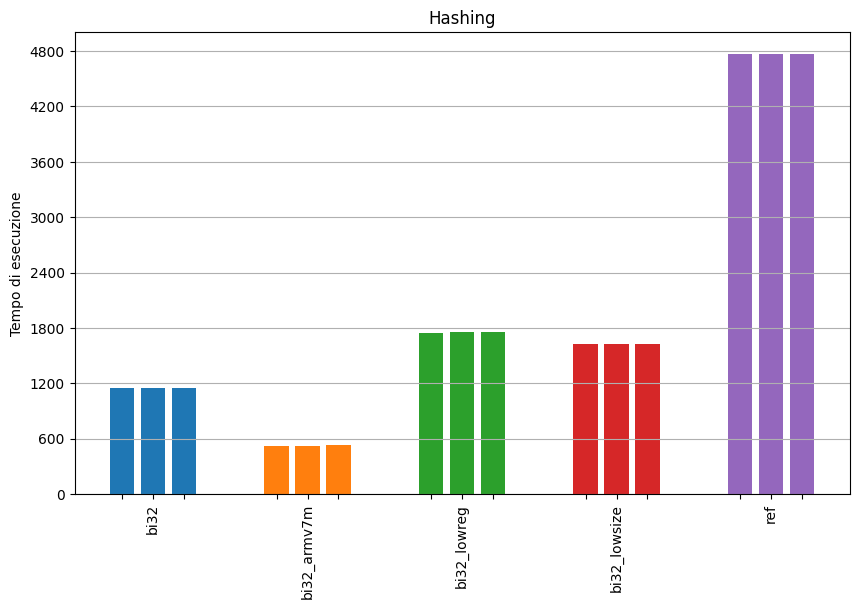

In [33]:
# Generazione hash
plotter(DATAFRAMES, "256B", IMPLEMENTATIONS, 600)

### PT 512 byte

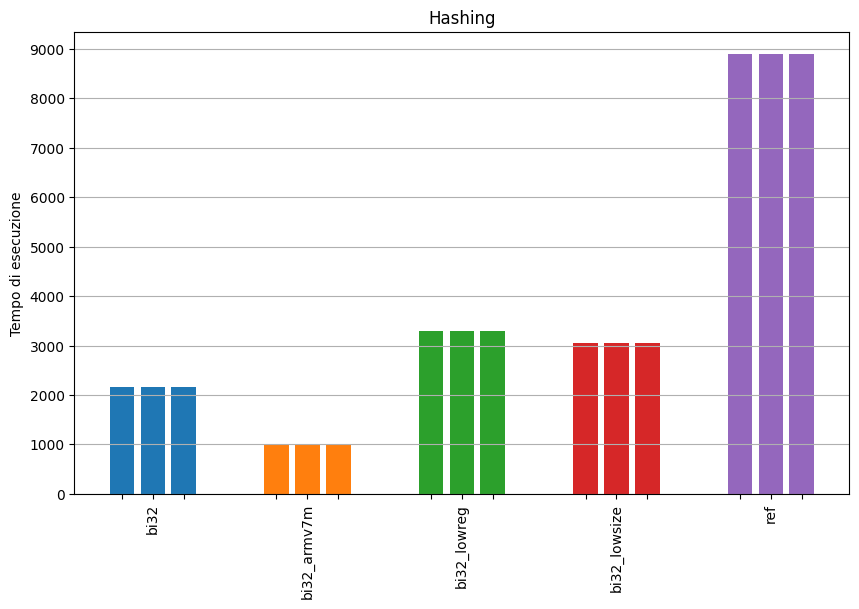

In [34]:
# Generazione hash
plotter(DATAFRAMES, "512B", IMPLEMENTATIONS, 1000)

### PT 1024 byte

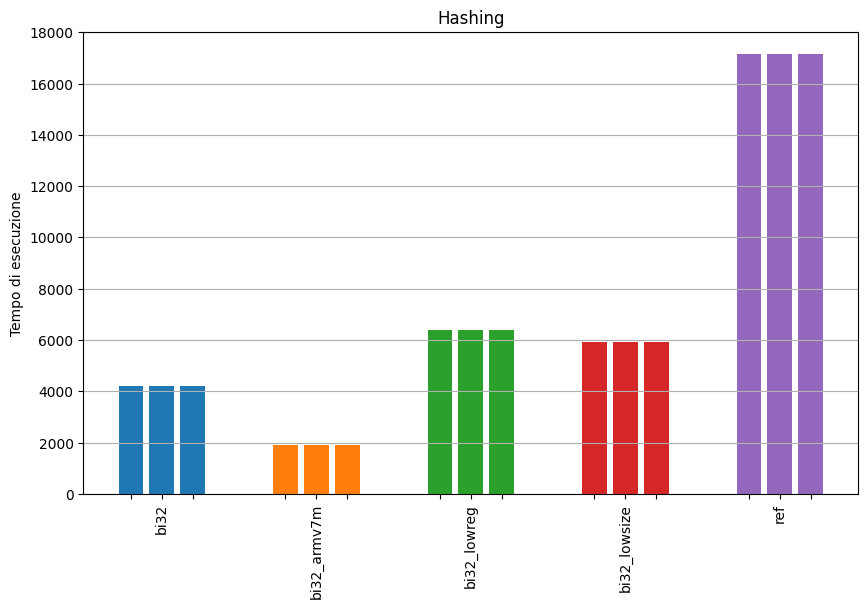

In [35]:
# Generazione hash
plotter(DATAFRAMES, "1024B", IMPLEMENTATIONS, 2000)

## Conclusioni

### Setup

In [36]:
def checker(dataframes: list, columns: list, index: int, check: FunctionType) -> None:
    for column in columns:
        test_series = dataframes[index][column]
        for i in range(len(dataframes)):
            if i == index:
                continue
            series = dataframes[i][column]
            assert check(test_series.min(), series.min())
            assert check(test_series.mean(), series.mean())
            assert check(test_series.max(), series.max())

    print("Nessuna AssertionError è stata sollevata")

In [37]:
def template(best: pd.DataFrame, worst: pd.DataFrame, columns: list, calculate: FunctionType) -> None:
    results = [[], [], []]
    for column in columns:
        best_series = best[column]
        worst_series = worst[column]
        results[0].append(calculate(best_series.min(), worst_series.min()))
        results[1].append(calculate(best_series.mean(), worst_series.mean()))
        results[2].append(calculate(best_series.max(), worst_series.max()))
    
    results = [
        [min(results[0]), max(results[0])],
        [min(results[1]), max(results[1])],
        [min(results[2]), max(results[2])]
    ]

    print(f"Rispetto alla misurazione minima: da {results[0][0]} a {results[0][1]}")
    print(f"Rispetto alla misurazione media: da {results[1][0]} a {results[1][1]}")
    print(f"Rispetto alla misurazione massima: da {results[2][0]} a {results[2][1]}")

In [38]:
def times(best: pd.DataFrame, worst: pd.DataFrame, columns: list) -> None:
    def calculate(best: int, worst: int) -> float:
        return np.around( worst/best, 2 )
    template(best, worst, columns, calculate)
    
    
def percentage_increase(best: pd.DataFrame, worst: pd.DataFrame, columns: list) -> None:
    def calculate(best: int, worst: int) -> float:
        return np.around( ((worst * 100) / best) - 100, 2 )
    template(best, worst, columns, calculate)

### Migliori implementazioni

L'implementazione `bi32_armv7m` è quella che ha ottenuto i tempi di esecuzione migliori in ogni possibile grandezza di PT considerata

Successivamente troviamo le restanti tre implementazioni della famiglia `bi32`

Notiamo come l'implementazione migliore è ottimizzata per architetture ARMv7-M, mentre le restanti migliori sono ottimizzate per architetture $32$ bit generiche

In [39]:
# Bi32_armv7m migliore implementazione
checker(DATAFRAMES, INDEX, 1, lambda x,y : x < y)

Nessuna AssertionError è stata sollevata


### Peggiori implementazioni

L'implementazione `ref` è quella che ha ottenuto i tempi di esecuzione peggiori in ogni possibile grandezza di PT considerata

Le prestazioni di questa implementazione sono terribili: infatti, è circa $2.7/3.25$ volte più lenta dell'implementazione `bi32_lowreg` e circa $9.05/9.7$ volte più lenta dell'implementazione migliore

Notiamo subito come le implementazioni peggiori sono quelle che cercano di ottimizzare architetture $32$ bit generiche oppure quella priva di ottimizzazioni

In [40]:
# Ref peggiore implementazione
checker(DATAFRAMES, INDEX, 4, lambda x,y : x > y)

Nessuna AssertionError è stata sollevata


In [41]:
# Ref quante volte è peggio di bi32_armv7m, migliore
times(bi32_armv7m, ref, INDEX)

Rispetto alla misurazione minima: da 9.05 a 9.65
Rispetto alla misurazione media: da 9.05 a 9.66
Rispetto alla misurazione massima: da 9.05 a 9.57


In [42]:
# Ref quanti punti percentuali è peggio di bi32_armv7m, migliore
percentage_increase(bi32_armv7m, ref, INDEX)

Rispetto alla misurazione minima: da 805.38 a 865.15
Rispetto alla misurazione media: da 805.44 a 866.01
Rispetto alla misurazione massima: da 804.53 a 856.72


In [43]:
# Ref quante volte è peggio di bi32_lowreg, seconda peggiore
times(bi32_lowreg, ref, INDEX)

Rispetto alla misurazione minima: da 2.68 a 3.22
Rispetto alla misurazione media: da 2.68 a 3.23
Rispetto alla misurazione massima: da 2.68 a 3.2


In [44]:
# Ref quanti punti percentuali è peggio di bi32_lowreg, seconda peggiore
percentage_increase(bi32_lowreg, ref, INDEX)

Rispetto alla misurazione minima: da 167.91 a 221.72
Rispetto alla misurazione media: da 167.91 a 222.65
Rispetto alla misurazione massima: da 167.9 a 220.5


### Dimensioni eseguibile

Potevamo aspettarcelo dal nome: l'implementazione `bi32_lowsize` è quella che ha una dimensione dell'eseguibile molto piccola, occupando circa il $2/3$\% dello spazio disponibile, mentre l'implementazione `bi32_armv7m` è quella più pesante, occupando circa il $4/5$\% dello spazio disponibile

Nonostante i pessimi tempi di esecuzione, l'implementazione `ref` fa parte delle implementazioni che hanno dimensione ridotta